<a href="https://colab.research.google.com/github/properallan/IM458-B/blob/master/twoPhaseFlow/twoPhaseFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install pynverse
from scipy.optimize import brentq as root
import cmath
from pynverse import inversefunc
import numpy as np
import matplotlib.pyplot as plt

tol = 1e-12

def diff(f, u, M, h=tol):
  # complex-step differentiation
  c = complex(u, h)
  df = f(c,M).imag/h
  return df

  Created wheel for pynverse: filename=pynverse-0.1.4.4-py3-none-any.whl size=6363 sha256=74e1952105de0fdefc5f49ad35df3c222122662b093edb34b5ec0034dda189e5
  Stored in directory: /root/.cache/pip/wheels/06/eb/74/006b76fdd8229ed3767fef546c825c2924f1def2d023929d9d
Successfully built pynverse


# 1D Two-Phase Flow in Porous Media

The problem is equivalent to an initial value problem, governed by a nonlinear PDE such as

$$
\frac{\partial u}{\partial t}+\frac{\partial f(u)}{\partial x} = 0
$$

## Non-convex flux function

The flux function $f(u)$ dictates the interaction relationship between the fluids. One possible nonlinear model is the Brooks-Corey model

$$
f_w(u) = \frac{u^2}{u^2 + \frac{(1-u)^2}{M}}
$$

In [3]:
def f_w(u, M):
  return u**2/(u**2+(1-u)**2/M)

, where $M$ is the ratio of viscosities, $M=\mu_o/\mu_w$. The analytical solution is given by

$$
u(x,t)=
\begin{cases}
0, \qquad & x/t & > & f'_w(u^\star)\\
u(x/t), \qquad & f'_w(u^\star) & \ge & x/t &\ge& f'_w(1) \\
1, \qquad &f'_w(1) & > & x/t
\end{cases}
$$

Differentiating $f_w$ with respect to $u$, yields

$$
f'_w(u) = -\frac{2M(u-1)u}{[(M+1)u^2-2u+1]^2}
$$



In [4]:
def df_w(u, M):
  #return diff(f_w, u, M)
  return -2*M*(u-1)*u/(((M+1)*u**2-2*u+1)**2)
  #return u**2

The shock location $u^\star$ is obtained from Rankine-Hugoniot condition

$$
f'_w(u^\star) = [f_w(u^\star)-f'_w(0)]/u^\star
$$

which was solved numerically by a rootfind *brentq* algorithm. Finally, the function $u(x/t)$ is computed as the inverse function $(f'_w)^{-1}(x/t)$ defined in the closed interval $[u^\star, 1]$.


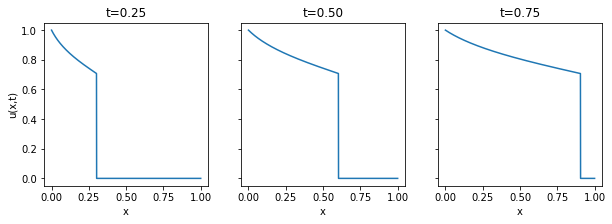

In [5]:
def u_nonconvex(x, t, M):
  f = lambda u,M: (f_w(u, M) - f_w(0, M))/(u - 0) - df_w(u, M)
  ustar = root(f, 0+tol,1-tol, args=(M))
  df_wustar = df_w(ustar, M)
  df_w1 = df_w(1, M)
  df_w_inv = inversefunc(df_w, domain=[ustar,1], args=(M))

  if x/t > df_wustar:
    return 0
  elif df_wustar >= x/t and x/t >= df_w1:
    return float(df_w_inv(x/t))
  elif df_w1 >= x/t:
    return 1

M = 1
x = 0
t = [0.25, 0.5, 0.75]
N = 1000
x = np.linspace(0,1,N)

u_sol = [np.array([u_nonconvex(xi, ti, M) for xi in x]) for ti in t]

fig, ax = plt.subplots(1,3, figsize=(10,3), sharey=True)
ax[0].plot(x,u_sol[0])
ax[0].set_xlabel(r'x')
ax[0].set_ylabel(r'u(x,t)')
ax[0].set_title(r't=0.25')

ax[1].plot(x,u_sol[1])
ax[1].set_xlabel(r'x')
ax[1].set_title(r't=0.50')

ax[2].plot(x,u_sol[2])
ax[2].set_xlabel(r'x')
ax[2].set_title(r't=0.75')

plt.show()


## Concave flux function

The flux function is given by

$$
f_w(u)=\frac{u}{u+\frac{(1-u)}{M}}
$$

And the PDE has a rarefaction wave solution

$$
u(x,t)=
\begin{cases}
0, \qquad & x/t & > & M\\
\frac{\sqrt{M\frac{t}{x}}-1}{M-1}, \qquad & M & \ge & x/t &\ge& 1/M \\
1, \qquad &1/M & > & x/t
\end{cases}
$$

For $M=2$, the solution is

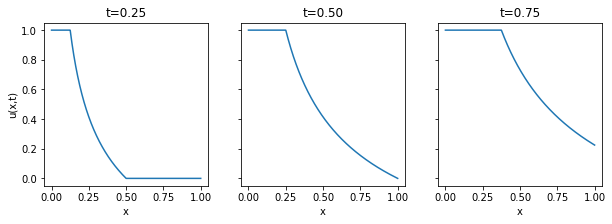

In [6]:
def u_concave(x, t, M):
  if x/t > M:
    return 0
  elif M >= x/t and x/t >= 1/M:
    return (np.sqrt(M*t/x)-1)/(M-1)
  elif 1/M >= x/t:
    return 1

M = 2
x = 0
t = [0.25, 0.5, 0.75]
N = 1000
x = np.linspace(0,1,N)

u_sol = [np.array([u_concave(xi, ti, M) for xi in x]) for ti in t]

fig, ax = plt.subplots(1,3, figsize=(10,3), sharey=True)
ax[0].plot(x,u_sol[0])
ax[0].set_xlabel(r'x')
ax[0].set_ylabel(r'u(x,t)')
ax[0].set_title(r't=0.25')

ax[1].plot(x,u_sol[1])
ax[1].set_xlabel(r'x')
ax[1].set_title(r't=0.50')

ax[2].plot(x,u_sol[2])
ax[2].set_xlabel(r'x')
ax[2].set_title(r't=0.75')

plt.show()

## Convex flux function

In the case of a flux function being strictly increasing, or *convex*

$$
f_w(u)=u^2
$$


, and if $u_l > u_r$, the solution is a shock wave propagating with speed $\sigma$, from Rankine-Hugoniot relation

$$
\begin{aligned}
\sigma &= \frac{f_w(u_l)^2 - f_w(u_r)^2}{u_l-u_r}\\
\sigma &= 1
\end{aligned}
$$

The solution is then

$$
u(x,t)=
\begin{cases}
u_l = 1, \qquad x/t < \sigma \\
u_r = 0, \qquad x/t > \sigma
\end{cases}
$$

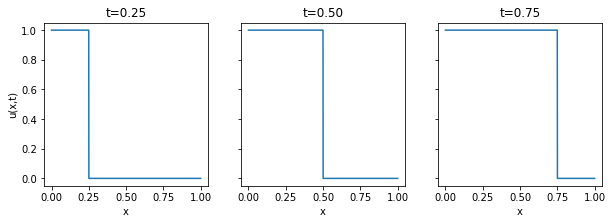

In [7]:
def u_convex(x, t):
  if x/t < 1:
    return 1
  elif x/t > 1:
    return 0

t = [0.25, 0.5, 0.75]
N = 1000
x = np.linspace(0,1,N)

u_sol = [np.array([u_convex(xi, ti) for xi in x]) for ti in t]

fig, ax = plt.subplots(1,3, figsize=(10,3), sharey=True)
ax[0].plot(x,u_sol[0])
ax[0].set_xlabel(r'x')
ax[0].set_ylabel(r'u(x,t)')
ax[0].set_title(r't=0.25')

ax[1].plot(x,u_sol[1])
ax[1].set_xlabel(r'x')
ax[1].set_title(r't=0.50')

ax[2].plot(x,u_sol[2])
ax[2].set_xlabel(r'x')
ax[2].set_title(r't=0.75')

plt.show()